In [115]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Let's make some data

We want a problem that is not linearly separable to show how poorly a linear classification would work here.

Note later that centering at zero is helpful for us.  We will make three classes, but you could add more or less if you wish by adjusting the variable K.  Feel free to add more dimensions, but it's harder to view beyond 2.

(-1.0, 1.0)

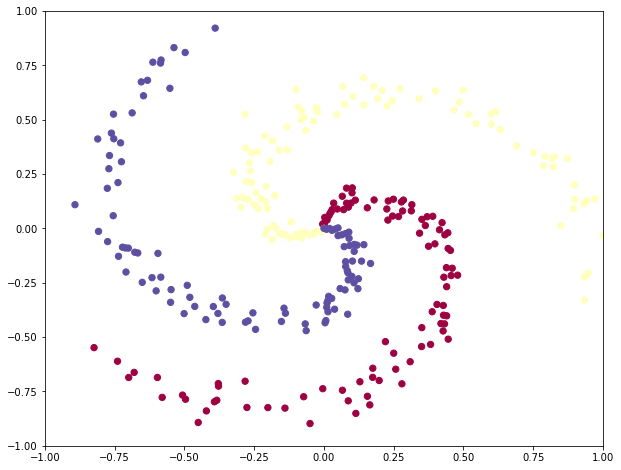

In [116]:
np.random.seed(10)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

# Train a Linear Classifier

First let's try to make a linear classifier that separates each class from the others. With more convenient data, this would not be a crazy thing to do.  Our linear functions will be of the form:

$f(X) = W^T\cdot X +b$

Here W is a matrix of weights and b is what's known as a bias variable.  You can just think of these as the slope and offset.  We also have the "targets" or truth labels for the data in each class: $y$.

How do you decide if a linear classifier is doing a good job?  We have N classes, so we will make three lines.  Each line should be drawn between a given class and the N-1 other classes.  If you have a perfect separation, that means that you have $f_1(X)<y_1$ for all instances of class 1 and $f_1(X)>y_i$ for all other classes.  Or vice versa if you multiple everything by -1.

In our case we have a 2D space and our function $f(X)$ will yield a 2D plane that will get increasingly positive in regions where the proper class exists and increasingly negative where the other classes exist.

Thus we can turn this result into a probability for correct classification using what we call the SoftMax function:

$S_i(X) = {e^{f_i(X)} \over \sum_j e^{f_j(X)}}$ 

This works well because if $f_i(x)$ is large, we map to a probability close to 1.0.  And, vice versa, if $f_i(X)$ is small and another $f_j(X)$ is large, we get a small probability.  And we find that $\sum S_i=1$, which allows useful interpretations of the scores.

In [117]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

Niter = 200

# gradient descent loop
num_examples = X.shape[0]
for i in range(Niter):
  
    # evaluate class scores, [N x K]
    # fhat = W^TX +b
    scores = np.dot(X, W) + b 
      
    # compute the class probabilities
    # this is softmax, converting to class probability
    # prob1 = exp(score1)/{exp(score1)+exp(score2)+...}
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
      
    # compute the loss: average cross-entropy loss and regularization
    # sometimes cross-entropy is called "log loss"
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples

    # This is L2 regularization, see Lecture 5
    reg_loss = 0.5*reg*np.sum(W*W)
    
    # Total loss is distance between the line and the data point
    # plus the L2 reg loss
    loss = data_loss + reg_loss

    if i % 10 == 0:
        print("iteration %d: loss %f" % (i, loss))
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
  
    dW += reg*W # regularization gradient
  
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.097504
iteration 10: loss 0.905411
iteration 20: loss 0.833606
iteration 30: loss 0.800791
iteration 40: loss 0.783627
iteration 50: loss 0.773818
iteration 60: loss 0.767859
iteration 70: loss 0.764077
iteration 80: loss 0.761598
iteration 90: loss 0.759932
iteration 100: loss 0.758790
iteration 110: loss 0.757995
iteration 120: loss 0.757435
iteration 130: loss 0.757036
iteration 140: loss 0.756750
iteration 150: loss 0.756543
iteration 160: loss 0.756393
iteration 170: loss 0.756283
iteration 180: loss 0.756203
iteration 190: loss 0.756143


In [118]:
#Just to make it clear what we're doing, let's peek at the weights
print("Weight matrix:\n",W)
print("\nBias matrix:\n",b)


# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('\n training accuracy: %.2f' % (np.mean(predicted_class == y)))

Weight matrix:
 [[ 1.14618415  1.18837632 -2.32314171]
 [-2.56334528  2.92416047 -0.36750339]]

Bias matrix:
 [[-0.04951159 -0.02462384  0.07413543]]

 training accuracy: 0.53


(-1.2, 1.2)

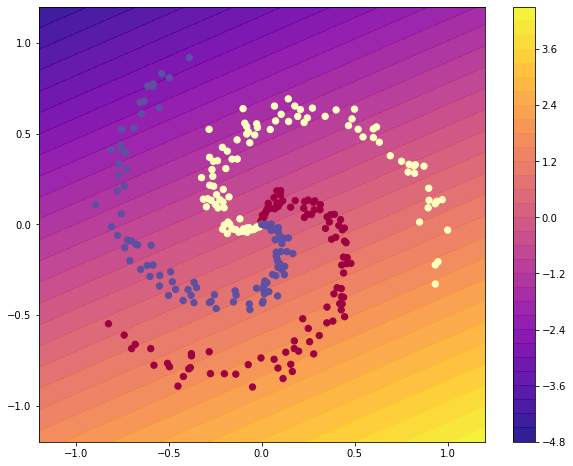

In [119]:
#Let's look to see what we got!
# Our 2D weights/variables define planes for each class

#make some x-values
xyMnx = 1.2
X_test = np.linspace(-1*xyMnx,xyMnx,N)
Y_test = np.linspace(-1*xyMnx,xyMnx,N)

Xt, Yt = np.meshgrid(X_test, Y_test)

#2D plane separating class 1 from classes 2 and 3
Z1 = Xt*W[0,0] + Yt*W[1,0] + b[0,0]

#2D plane separating class 2 from classes 1 and 3
Z2 = Xt*W[0,1] + Yt*W[1,1] + b[0,1]

#2D plane separating class 3 from classes 1 and 2
Z3 = Xt*W[0,2] + Yt*W[1,2] + b[0,2]


fig = plt.figure()
cp = plt.contourf(Xt, Yt, Z1,30, cmap=plt.cm.plasma, alpha=0.9)
plt.colorbar(cp)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(-1*xyMnx,xyMnx)
plt.ylim(-1*xyMnx,xyMnx)

(-1.8976062864947214, 1.902393713505282)

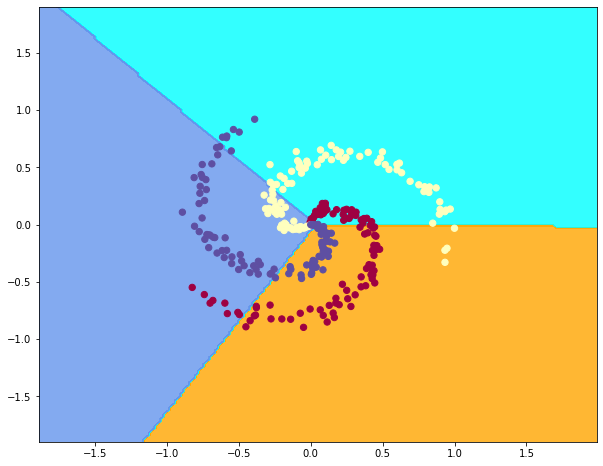

In [120]:
# What we'd really like, though, is to classify space where
# each class score has the highest probability.
# This divides the space into Voronoi regions

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

# Train a one-layer neural network

The linear classifier approach was fine, but it didn't correctly classify in more than ~50% of cases.  So we can ramp this up to a neural network.  We are still going to make linear functions of our input variables, $f(X) = W^TX+b$, but now we will use activation functions to introduce a non-linearity.  In this example we'll use "Rectified Linear Units", aka ReLU, as our activation function.  

This NN will have one input layer (2 inputs), one hidden layer (100 neurons by default) and one output node that receives all of the activation function outputs. In the previous example we had $2\times 3 + 3 =9$ weights.  Now we will have $2\times 100 + 100=300$ weights for the inputs to the hidden layer and $100 \times 3 + 3 = 303$ weights for the output node.  So we had better be able to improve!

In [121]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
    # evaluate class scores, [N x K]
    # note that fhat is the same as before: fhat=W^T X + b
    # but now we pass the linear sum into a ReLU activation function
    # this provides a nonlinearity that wasn't there for the previous case
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation

    # this is the fully-connected output layer, just summing the output
    # of the activation functions
    scores = np.dot(hidden_layer, W2) + b2
  
    # compute the class probabilities
    # this is softmax, converting to class probability
    # prob1 = exp(score1)/{exp(score1)+exp(score2)+...}
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    
    # this time we have two weight matrices, so we need to include
    # both in the L2 regularization
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
  
    if i % 1000 == 0:
        print("iteration %d: loss %f" % (i, loss))
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W
  
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 1.098595
iteration 1000: loss 0.735162
iteration 2000: loss 0.269057
iteration 3000: loss 0.248122
iteration 4000: loss 0.243408
iteration 5000: loss 0.242365
iteration 6000: loss 0.241920
iteration 7000: loss 0.241704
iteration 8000: loss 0.241546
iteration 9000: loss 0.241466


In [122]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98


(-1.8976062864947214, 1.902393713505282)

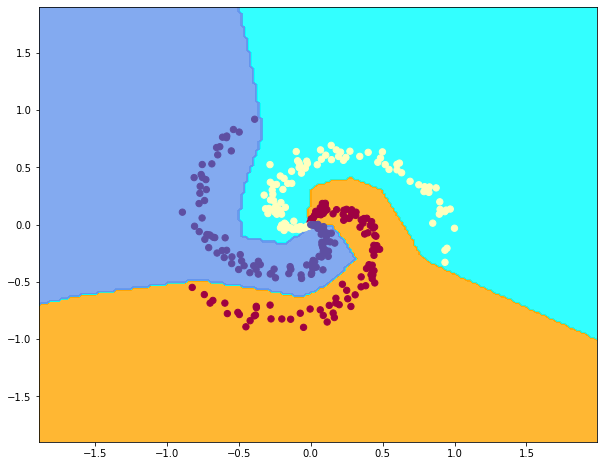

In [123]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

# How well can we do with unsupervised learning?

As an example of unsupervised learning, we can try adding in a "k Nearest Neighbor" algorithm (kNN).  Now we're going to borrow from scikit-learn for the kNN algorithm to show how that works for us.


 training accuracy: 0.90

 training accuracy: 0.99


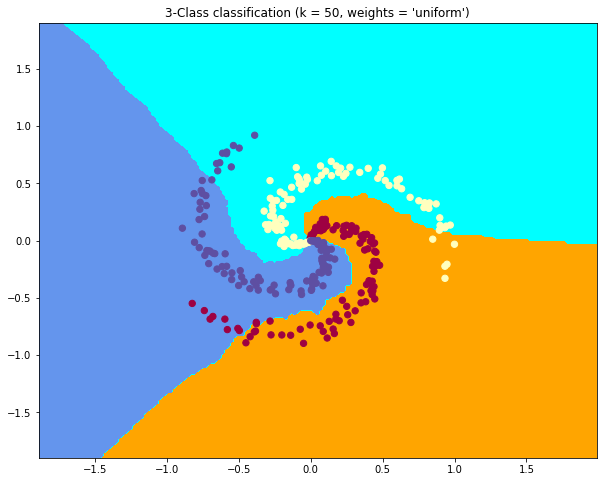

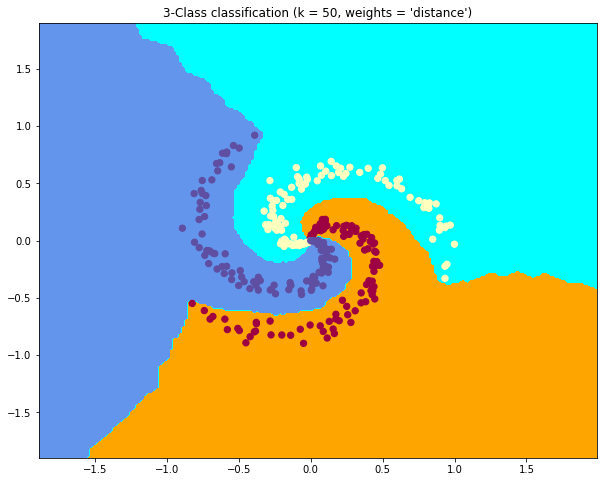

In [134]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, metrics

# Primary hyper parameter for kNN
n_neighbors = 10

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    
    # Most scikit-learn algorithm use the "fit" method to perform their role
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))
    
    # evaluate training set accuracy
    scores = clf.predict(X)

    print('\n training accuracy: %.2f' % metrics.accuracy_score(scores,y))

plt.show()
